## Notebook for doing single-x cluster analysis using just scanpy

copied [scanpy tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)

In [1]:
!date

Mon Jul 19 11:40:07 EDT 2021


#### import libraries and set notebook variables

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
# parameters
cohort = 'aging'

# directories
home_dir = '/labshare/raph/datasets/adrd_neuro'
wrk_dir = f'{home_dir}/{cohort}'
results_dir = f'{wrk_dir}/demux'

# in files
input_data_file = f'{results_dir}/{cohort}.h5ad'

# out files
results_file = f'{results_dir}/{cohort}.scanpy.h5ad'

In [4]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.1 anndata==0.7.5 umap==0.5.0 numpy==1.19.2 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.0 leidenalg==0.8.3


#### open the data file

In [5]:
%%time
adata = sc.read(input_data_file, cache=True)

CPU times: user 382 ms, sys: 1.43 s, total: 1.81 s
Wall time: 1.81 s


In [6]:
adata

AnnData object with n_obs × n_vars = 168090 × 36601
    obs: 'pool_name', 'Sample_id', 'Tissue_source', 'Brain_region', 'Clinical_diagnosis', 'Age', 'Sex', 'donor_id', 'lane_num'

#### Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:02)


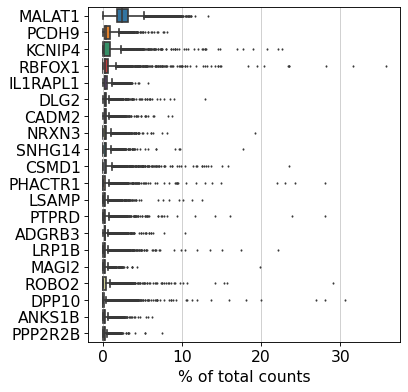

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )

#### Basic filtering

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

/home/gibbsr/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
filtered out 1954 genes that are detected in less than 3 cells


#### assemble some information about mitochondrial genes, which are important for quality control.

In [9]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

#### A violin plot of some of the computed quality measures:

- the number of genes expressed in the count matrix
- the total counts per cell
- the percentage of counts in mitochondrial genes


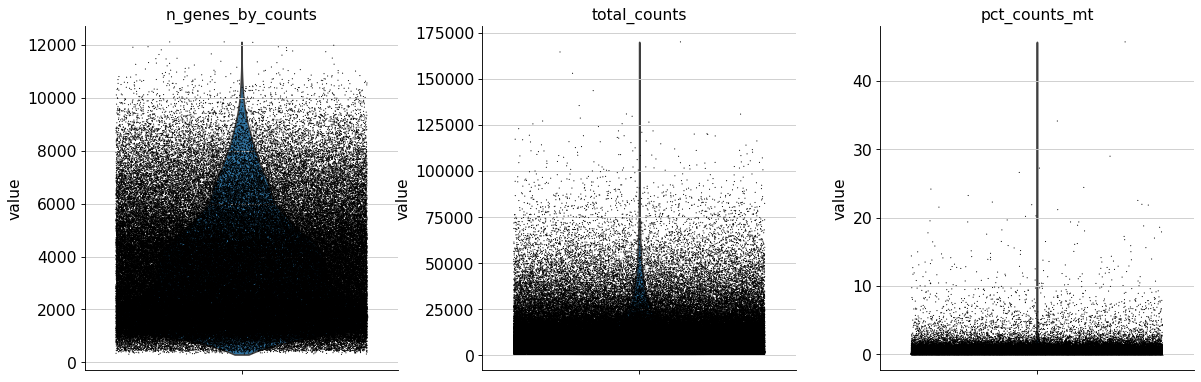

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

#### Remove cells that have too many mitochondrial genes expressed or too many total counts

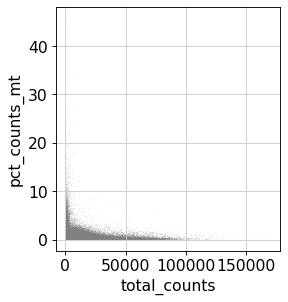

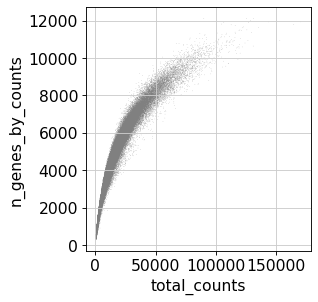

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

#### Actually do the filtering by slicing the AnnData object.

In [12]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

/home/gibbsr/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/gibbsr/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


#### Total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads per cell, so that counts become comparable among cells.

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4)

/home/gibbsr/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)


#### Logarithmize the data

In [14]:
sc.pp.log1p(adata)

#### Identify highly-variable genes.

In [15]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


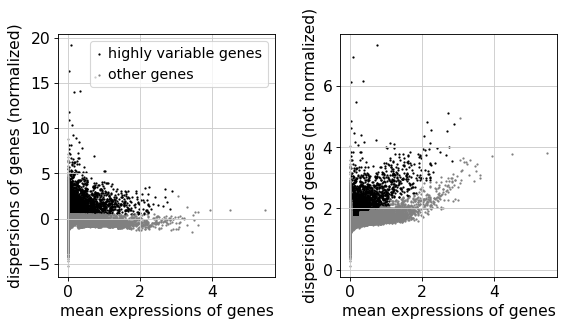

In [16]:
sc.pl.highly_variable_genes(adata)

#### Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

In [17]:
adata.raw = adata

#### Actually do the filtering

In [18]:
adata = adata[:, adata.var.highly_variable]

/home/gibbsr/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


#### Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [19]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:01:37)


#### Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [20]:
sc.pp.scale(adata, max_value=10)

#### Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [21]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
/home/gibbsr/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    with n_comps=50
    finished (0:00:16)


#### We can make a scatter plot in the PCA coordinates, but we will not use that later on.

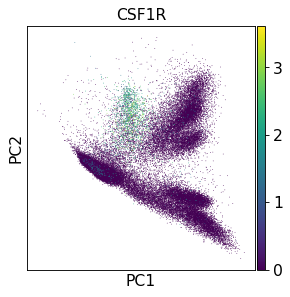

In [22]:
sc.pl.pca(adata, color='CSF1R')

#### Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.

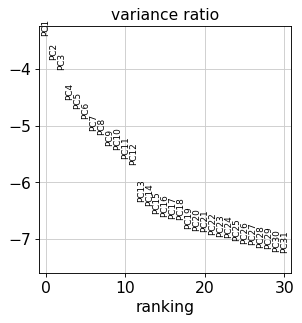

In [23]:
sc.pl.pca_variance_ratio(adata, log=True)

#### Save the result

In [24]:
%%time
adata.write(results_file)

CPU times: user 733 ms, sys: 894 ms, total: 1.63 s
Wall time: 22.8 s


In [25]:
adata

AnnData object with n_obs × n_vars = 65354 × 4260
    obs: 'pool_name', 'Sample_id', 'Tissue_source', 'Brain_region', 'Clinical_diagnosis', 'Age', 'Sex', 'donor_id', 'lane_num', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

#### Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.

In [26]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)


#### Embedding the neighborhood graph

In [27]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:56)


In [28]:
marker_genes = ["SLC17A7", "RORB", "FEZF2", "GAD1", "SST", "VIP", "PVALB", 
                "PDGFRA", "OLIG2", "PLP1", "MOBP", "SLC1A2", "SLC1A3", "GFAP", "AQP4", 
                "P2RY12", "ITGAM", "CSF1R", "CX3CR1","CLDN5", "COLEC12"]

marker_genes = list(set(marker_genes) & set(adata.var_names))

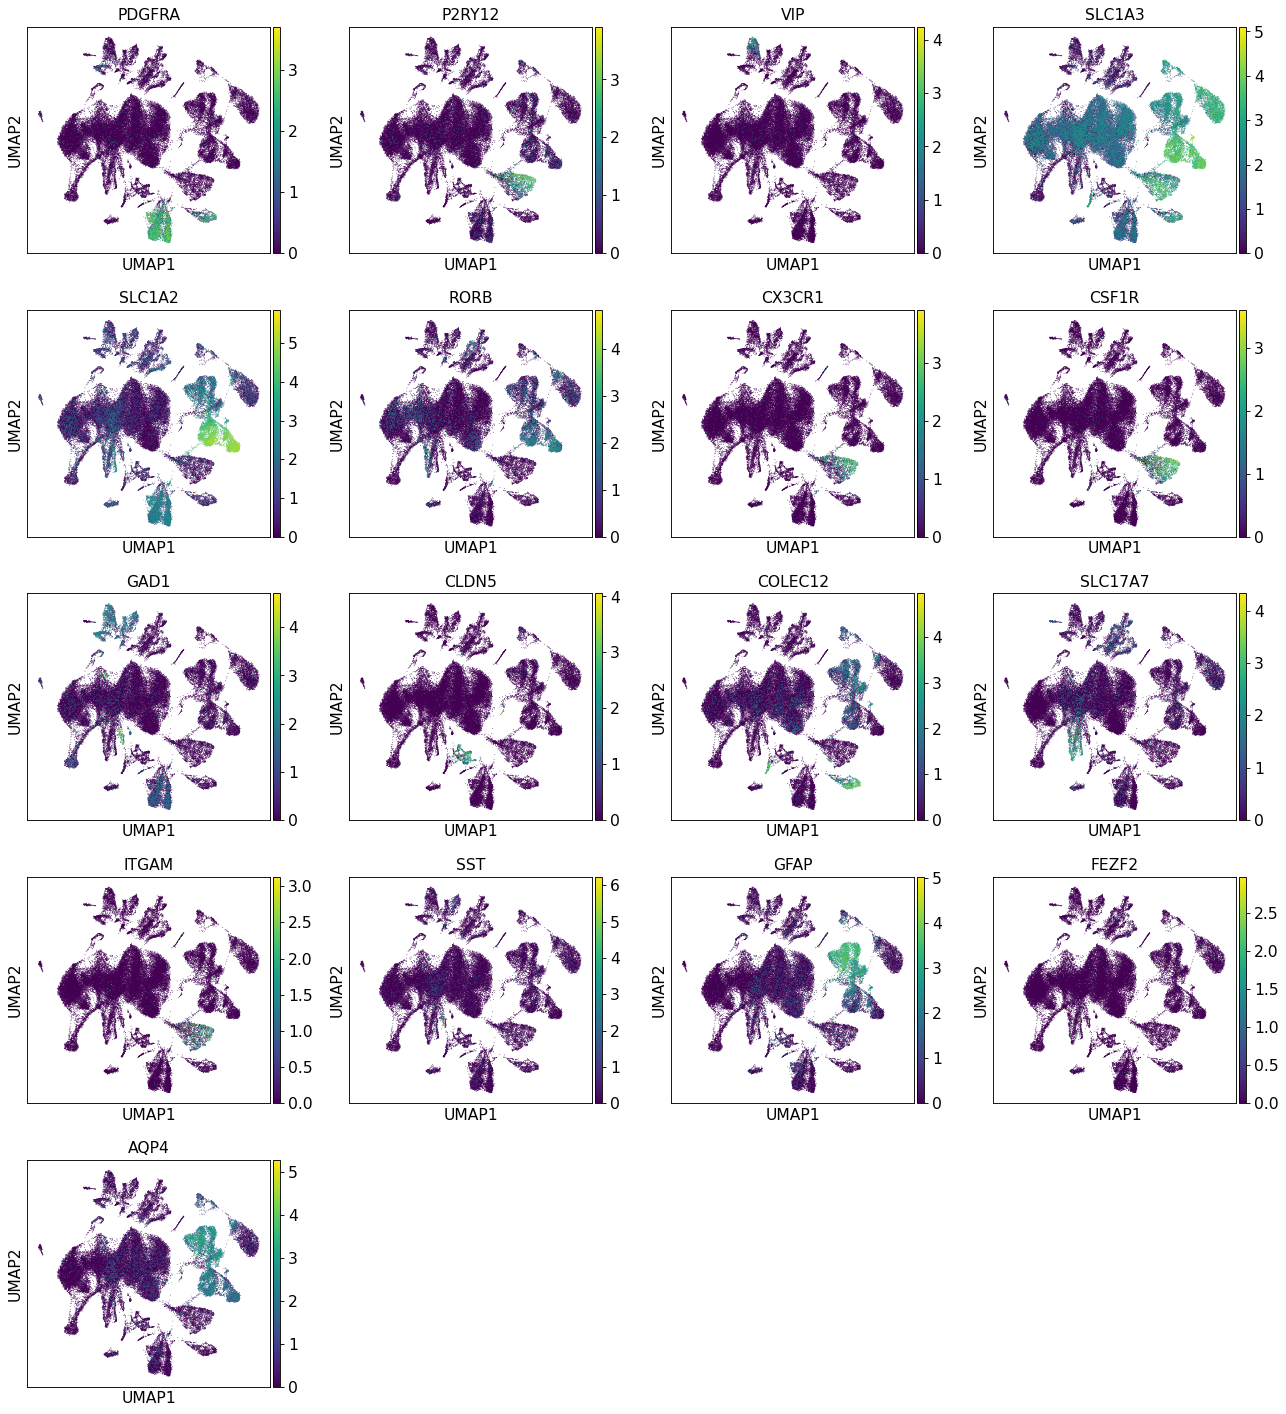

In [29]:
sc.pl.umap(adata, color=marker_genes)

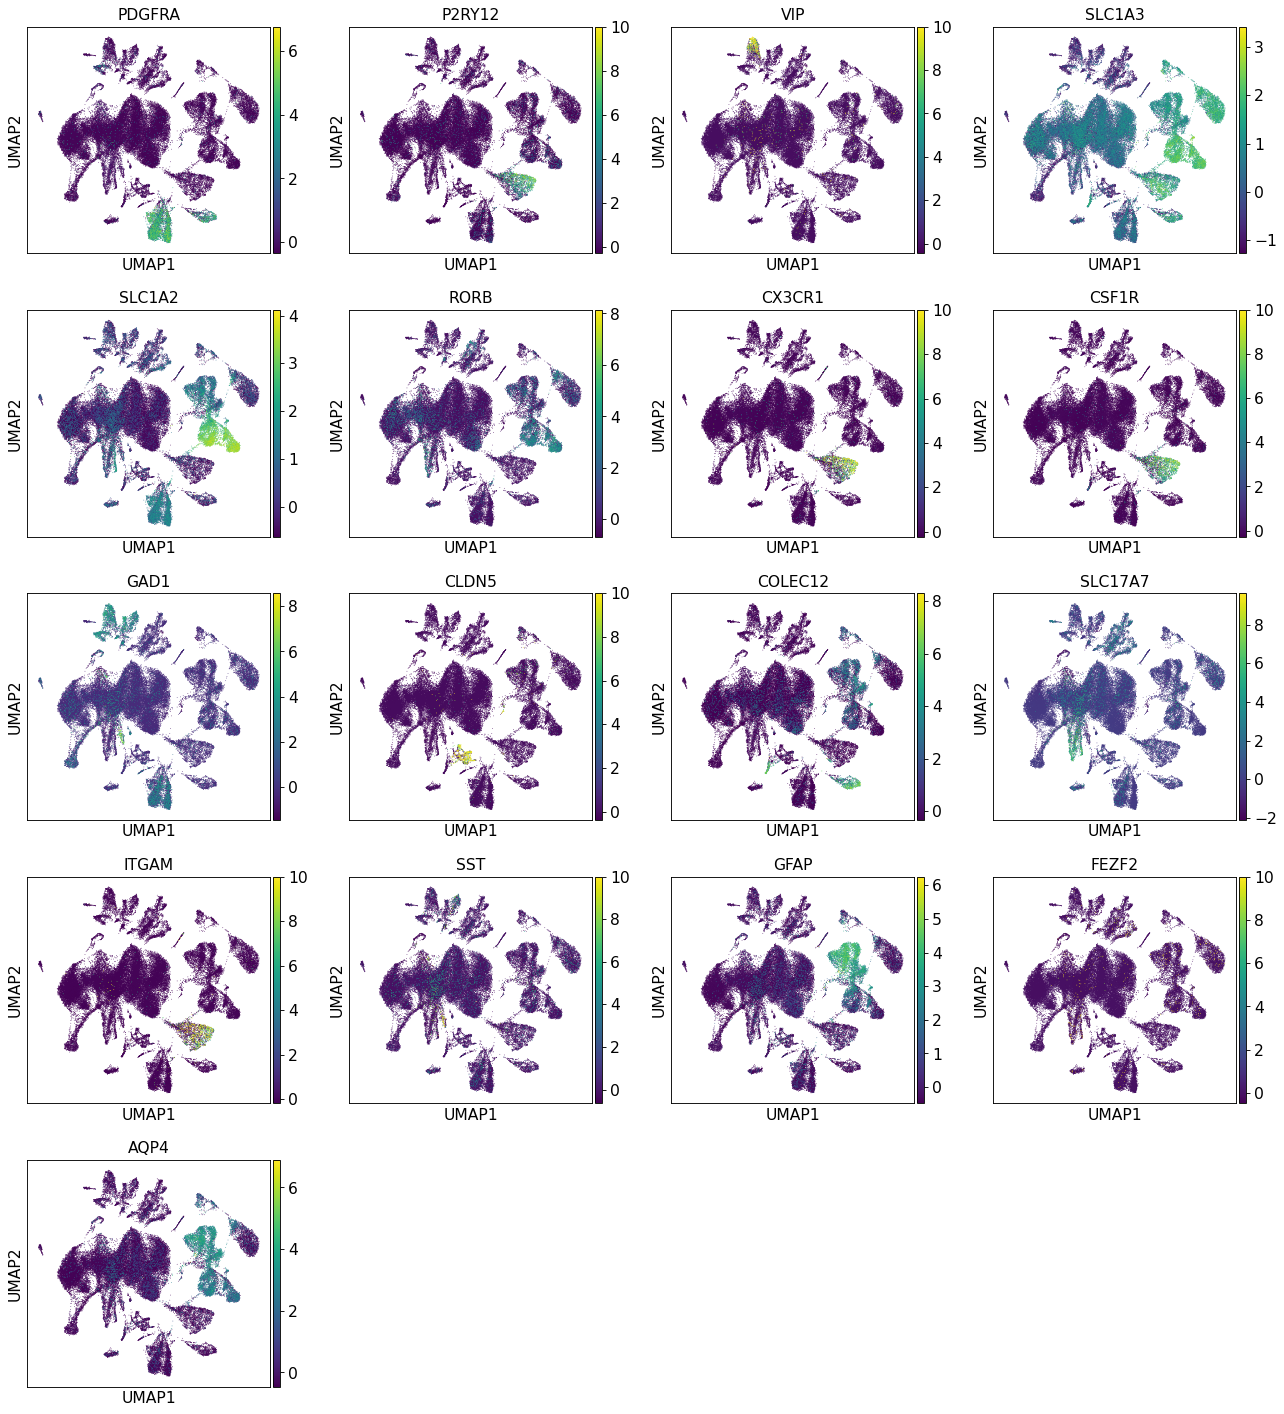

In [30]:
sc.pl.umap(adata, color=marker_genes, use_raw=False)

#### Clustering the neighborhood graph

In [31]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 30 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:07)


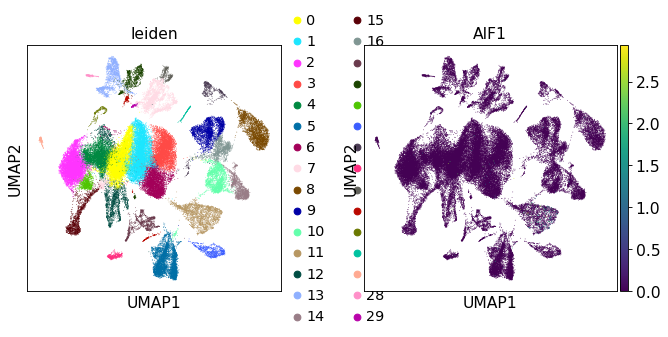

In [32]:
sc.pl.umap(adata, color=['leiden', 'AIF1'])

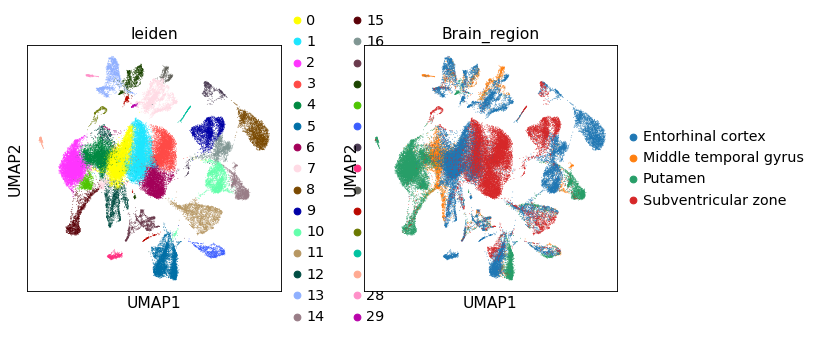

In [50]:
sc.pl.umap(adata, color=['leiden', 'Brain_region'])

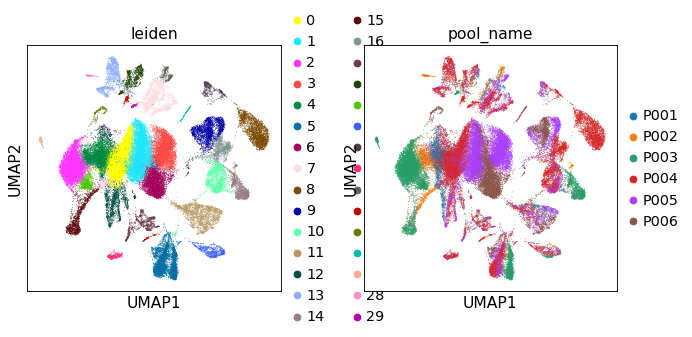

In [51]:
sc.pl.umap(adata, color=['leiden', 'pool_name'])

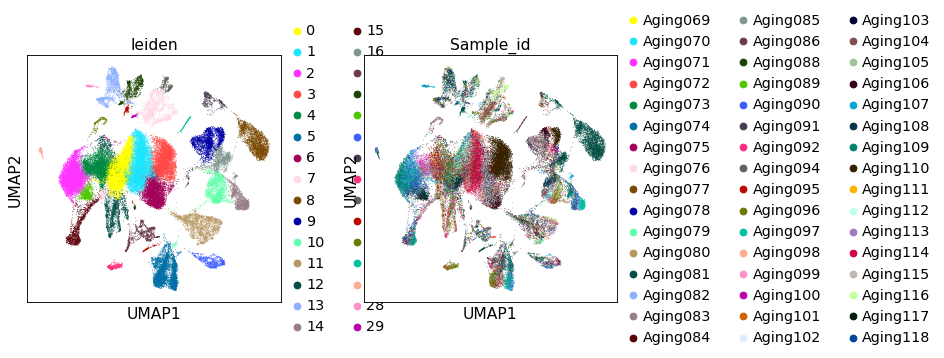

In [52]:
sc.pl.umap(adata, color=['leiden', 'Sample_id'])

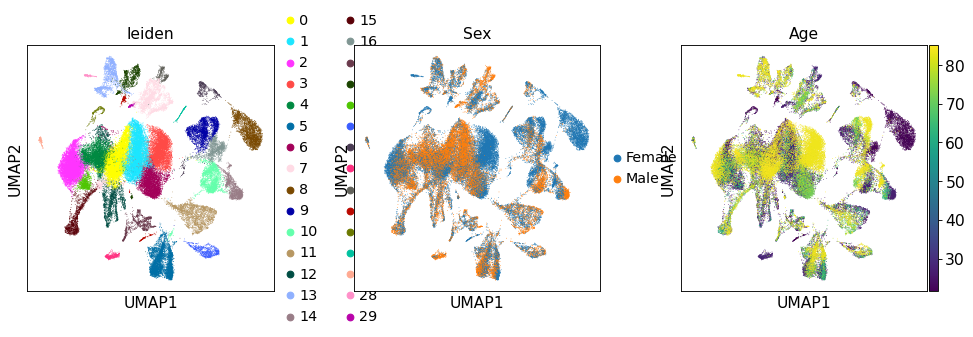

In [53]:
sc.pl.umap(adata, color=['leiden', 'Sex', 'Age'])

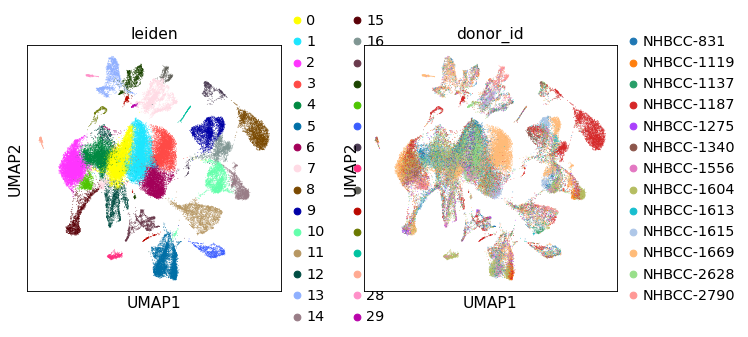

In [54]:
sc.pl.umap(adata, color=['leiden', 'donor_id'])

#### save the results

In [33]:
adata.write(results_file)

#### Finding marker genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:17)


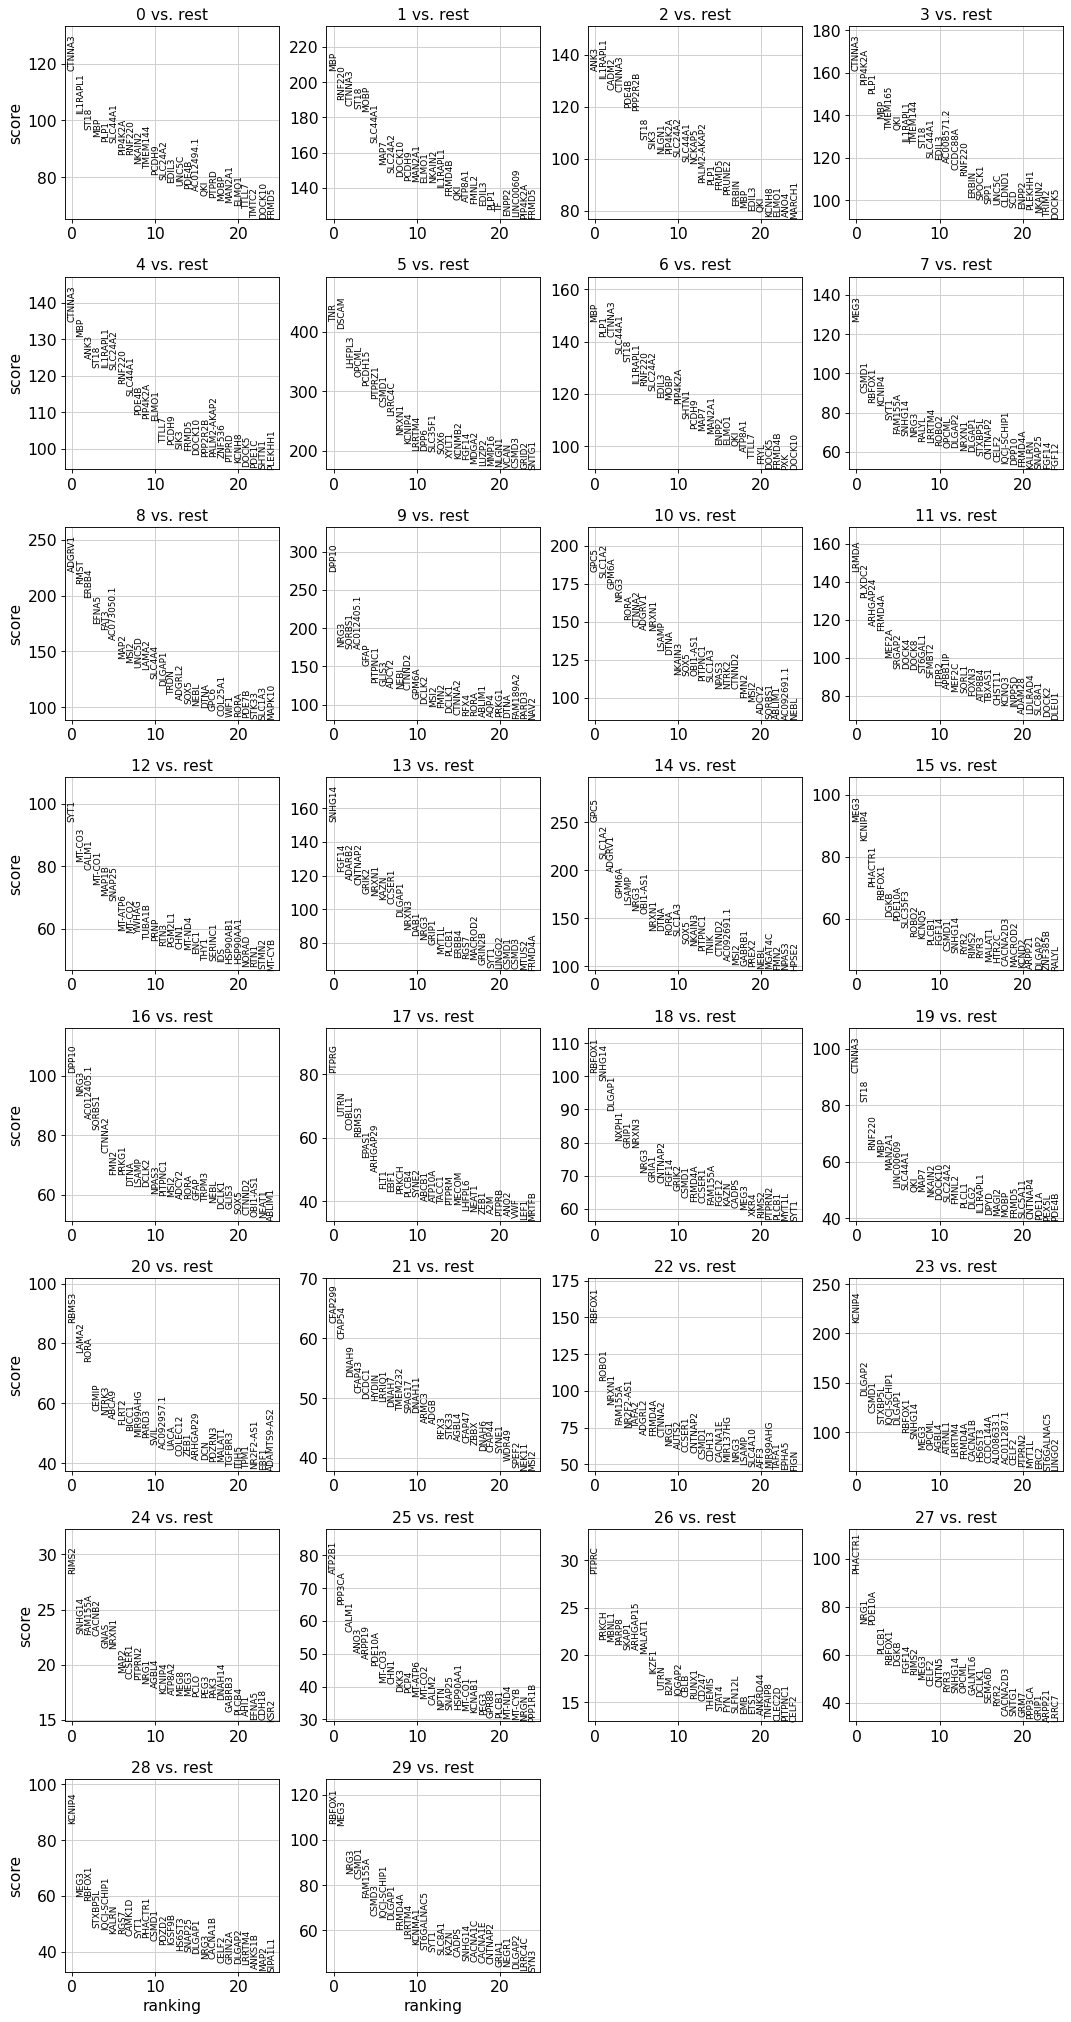

In [34]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [35]:
sc.settings.verbosity = 2  # reduce the verbosity

#### The result of a Wilcoxon rank-sum (Mann-Whitney-U) test is very similar. We recommend using the latter in publications, see e.g., Sonison & Robinson (2018). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:02:06)


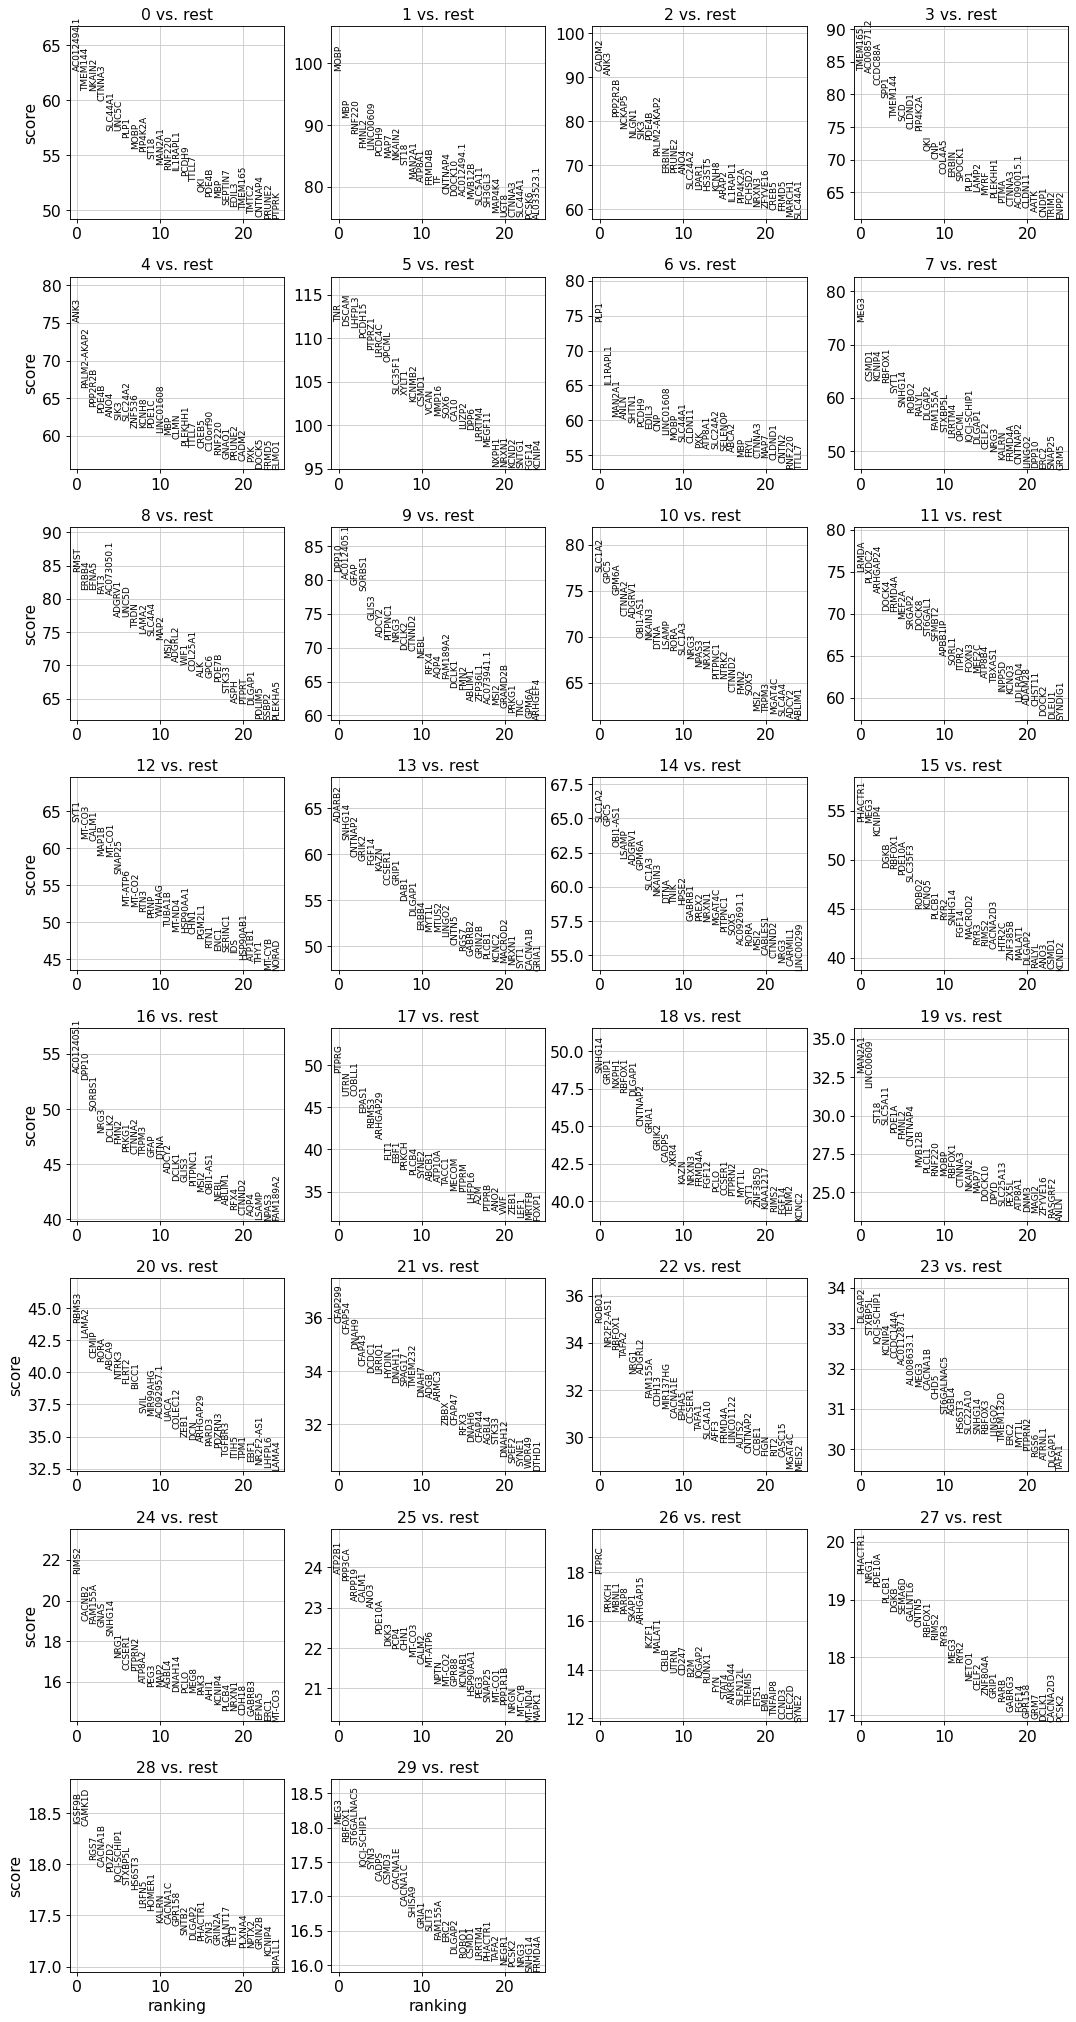

In [36]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

#### save the results

In [37]:
adata.write(results_file)

#### As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by Natranos et al. (2018). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. Clark et al. (2014) has more details.

ranking genes
/home/gibbsr/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
    finished (0:05:47)


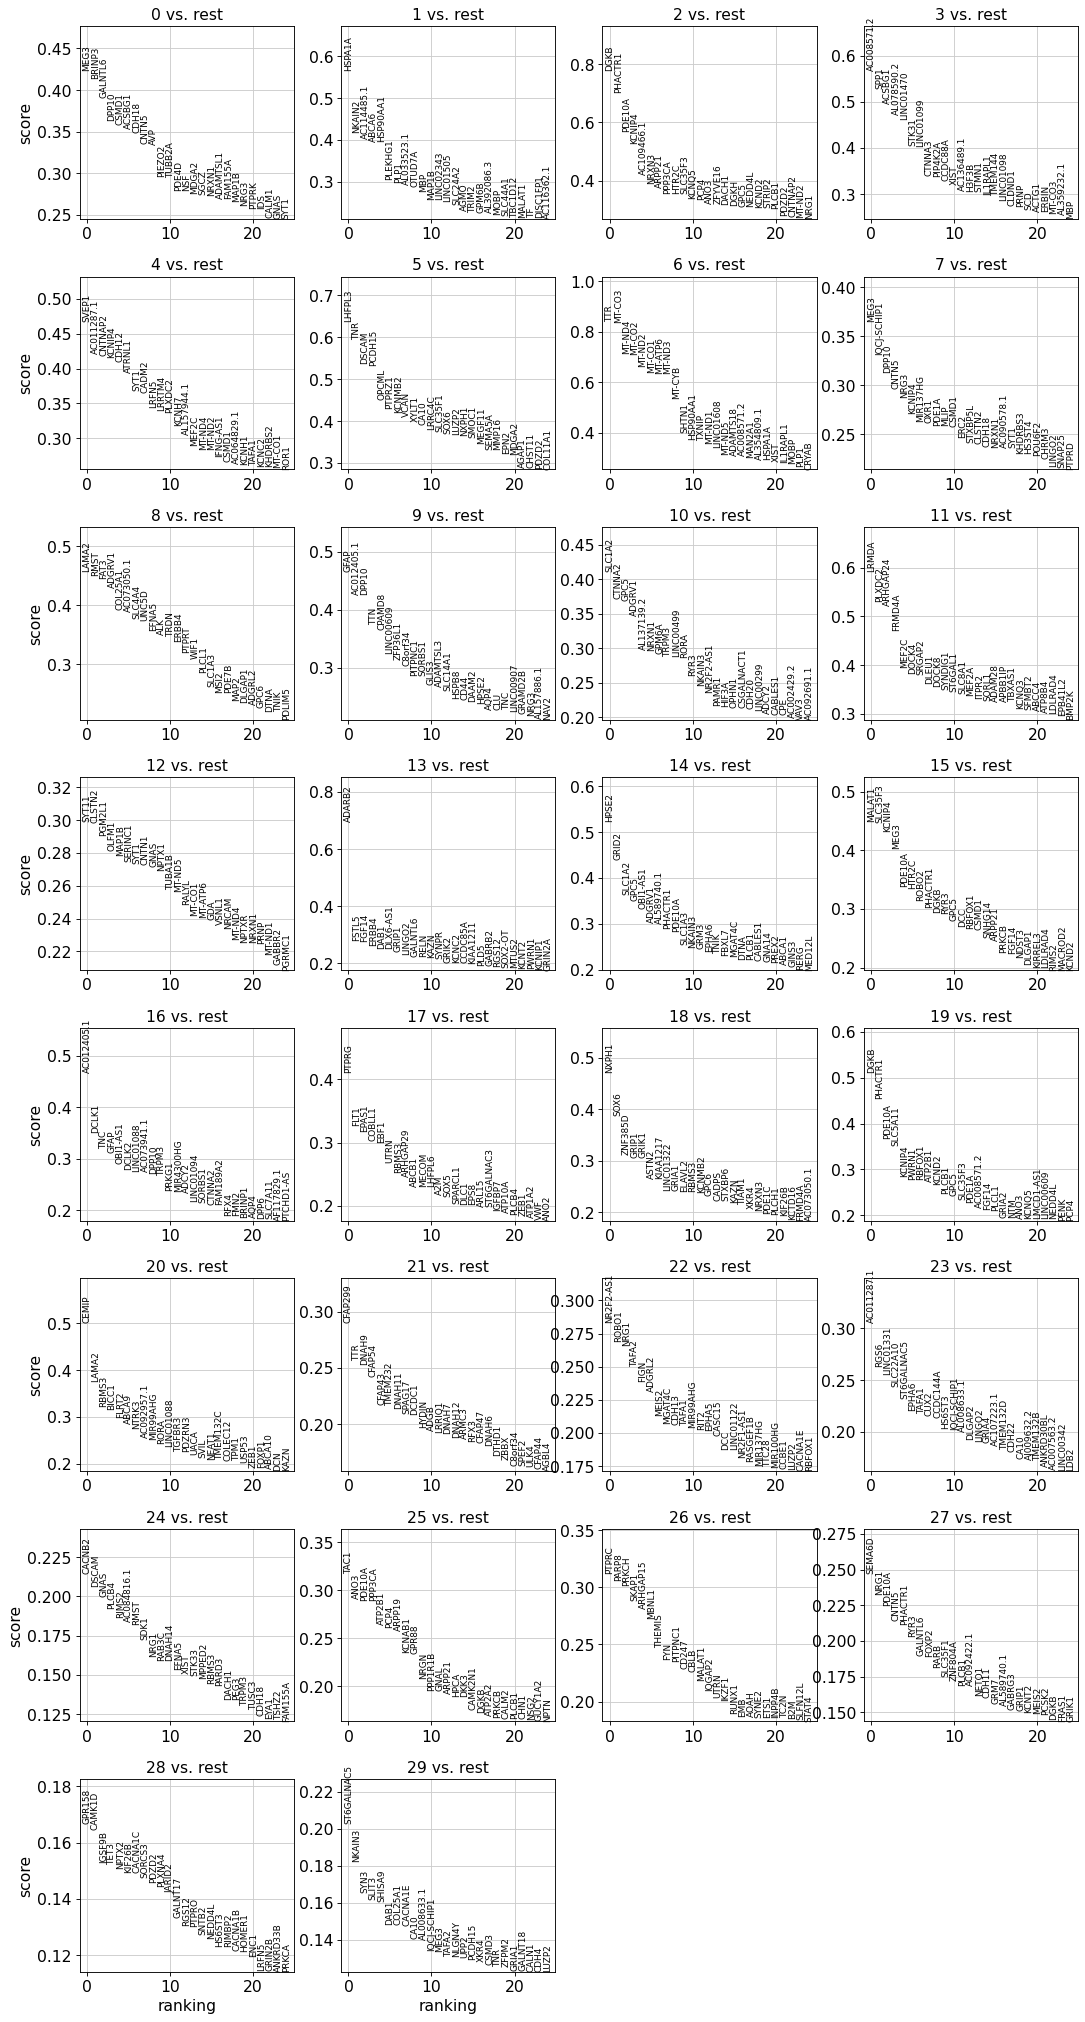

In [38]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [39]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, …, 7 in a dataframe.

In [40]:
display(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5))

0          1        2           3            4       5         6  \
0  AC012494.1       MOBP    CADM2     TMEM165         ANK3     TNR      PLP1   
1     TMEM144        MBP     ANK3  AC008571.2  PALM2-AKAP2   DSCAM  IL1RAPL1   
2      NKAIN2     RNF220  PPP2R2B     CCDC88A      PPP2R2B  LHFPL3    MAN2A1   
3      CTNNA3      FMNL2   NCKAP5        SPP1        PDE4B  PCDH15      ANLN   
4     SLC44A1  LINC00609    NLGN1     TMEM144         ANO4  PTPRZ1     SHTN1   

        7           8           9  ...     20       21         22  \
0    MEG3        RMST       DPP10  ...  RBMS3  CFAP299      ROBO1   
1   CSMD1       ERBB4  AC012405.1  ...  LAMA2   CFAP54  NR2F2-AS1   
2  KCNIP4       EFNA5        GFAP  ...  CEMIP    DNAH9     RBFOX1   
3  RBFOX1        FAT3      SORBS1  ...   RORA   CFAP43      TAFA2   
4    SYT1  AC073050.1       GLIS3  ...  ABCA9    DCDC1       NRG1   

            23       24      25     26       27       28           29  
0       DLGAP2    RIMS2  ATP2B1  PTPRC  PHACTR1   IGSF9B         MEG3  
1      STXBP5L   CACNB2  PPP3CA  PRKCH     NRG1   CAMK1D       RBFOX1  
2  IQCJ-SCHIP1  FAM155A  ARPP19  MBNL1   PDE10A     RGS7   ST6GALNAC5  
3       KCNIP4     GNAS   CALM1  PARP8    PLCB1  CACNA1B  IQCJ-SCHIP1  
4     CCDC144A   SNHG14    ANO3  SKAP1     DGKB    PDZD2         SYN3  

[5 rows x 30 columns]

Get a table with the scores and groups

In [41]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n  0_p        1_n  1_p      2_n  2_p         3_n  3_p  \
0  AC012494.1  0.0       MOBP  0.0    CADM2  0.0     TMEM165  0.0   
1     TMEM144  0.0        MBP  0.0     ANK3  0.0  AC008571.2  0.0   
2      NKAIN2  0.0     RNF220  0.0  PPP2R2B  0.0     CCDC88A  0.0   
3      CTNNA3  0.0      FMNL2  0.0   NCKAP5  0.0        SPP1  0.0   
4     SLC44A1  0.0  LINC00609  0.0    NLGN1  0.0     TMEM144  0.0   

           4_n  4_p  ...    25_n           25_p   26_n          26_p     27_n  \
0         ANK3  0.0  ...  ATP2B1  8.374239e-126  PTPRC  3.667301e-72  PHACTR1   
1  PALM2-AKAP2  0.0  ...  PPP3CA  5.919285e-124  PRKCH  1.667320e-60     NRG1   
2      PPP2R2B  0.0  ...  ARPP19  5.918767e-119  MBNL1  2.206255e-60   PDE10A   
3        PDE4B  0.0  ...   CALM1  1.559213e-118  PARP8  1.012939e-59    PLCB1   
4         ANO4  0.0  ...    ANO3  3.466007e-117  SKAP1  7.326164e-58     DGKB   

           27_p     28_n          28_p         29_n          29_p  
0  2.481457e-84   IGSF9B  1.341014e-75         MEG3  6.630185e-73  
1  6.759359e-83   CAMK1D  2.005218e-75       RBFOX1  7.995054e-71  
2  2.234627e-82     RGS7  7.850748e-73   ST6GALNAC5  1.502474e-70  
3  4.791401e-80  CACNA1B  3.079009e-72  IQCJ-SCHIP1  4.468561e-68  
4  7.866620e-79    PDZD2  7.016509e-72         SYN3  7.706156e-68  

[5 rows x 60 columns]

Compare to a single cluster:

ranking genes
    finished (0:00:17)


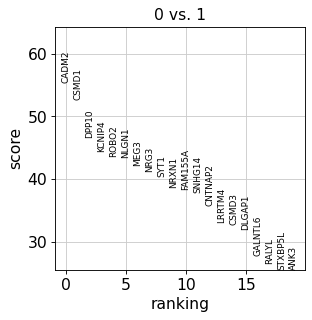

In [42]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use sc.pl.rank_genes_groups_violin.

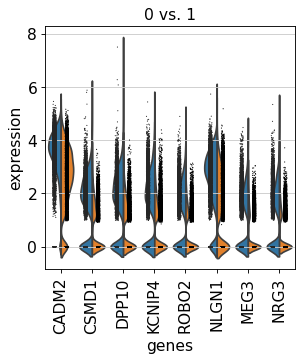

In [43]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reload the object with the computed differential expression (i.e. DE via a comparison with the rest of the groups):

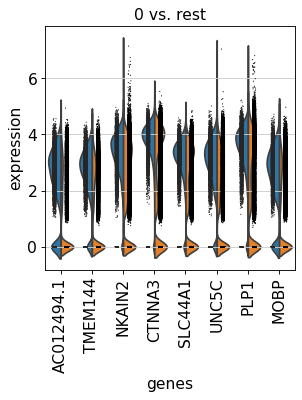

In [44]:
adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.M

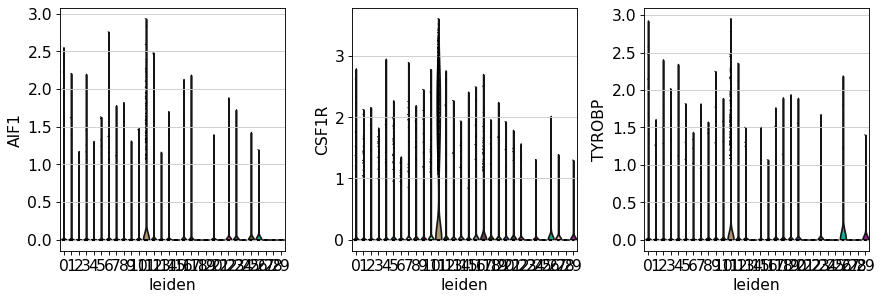

In [45]:
sc.pl.violin(adata, ['AIF1', 'CSF1R', 'TYROBP'], groupby='leiden')

Actually mark the cell types.

In [ ]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False)

Now that we annotated the cell types, let us visualize the marker genes.

In [ ]:
sc.pl.dotplot(adata, ['AIF1', 'CSF1R', 'TYROBP'], groupby='leiden');

There is also a very compact violin plot.

In [ ]:
sc.pl.stacked_violin(adata, ['AIF1', 'CSF1R', 'TYROBP'], groupby='leiden', rotation=90);

During the course of this analysis, the AnnData accumlated the following annotations.

In [ ]:
adata